## Test technique Equancy 

Alexia Huc-Lhuillery 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.impute import SimpleImputer 

In [2]:
# à changer si le dataset n'est pas dans le même dossier 
df = pd.read_csv("data.csv")

In [3]:
print(df.shape)
print(df.isnull().any())
print(df.isnull().sum().sort_values(ascending=False))

(9582, 6)
Entreprise       True
Metier           True
Technologies    False
Diplome         False
Experience       True
Ville           False
dtype: bool
Experience      94
Metier          19
Entreprise      17
Technologies     0
Diplome          0
Ville            0
dtype: int64


### Le dataset contient 9582 observations avec 6 colonnes, avec des valeurs manquantes pour certaines variables : 17 pour entreprise, 19 pour metier et 94 pour experience 

In [4]:
print(df.columns)
print(df.head())
print(df.dtypes)

# on change le type de données pour Experience, de object à float pour pouvoir calculer la moyenne et la médiane

# le problème provient des données qui ont une virgule, il faut la remplacer par un point pour pouvoir 
# convertir la valeur en float 

def str_to_float(x):
    if type(x) == str:
        x = x.replace(',', '.')
    return float(x)

df.Experience = df.Experience.apply(str_to_float)

print(df.dtypes)

# calcul de la médiane et de la moyenne de la colonne

median = df.Experience.median()
mean = df.Experience.mean()

# on remplace pour les métiers de data scientist et de data engineer 

df.loc[df.Metier == 'Data scientist', ['Experience']] = df.loc[df.Metier == 'Data scientist', ['Experience']].fillna(median)
df.loc[df.Metier == 'Data engineer', ['Experience']] = df.loc[df.Metier == 'Data engineer', ['Experience']].fillna(mean)


Index(['Entreprise', 'Metier', 'Technologies', 'Diplome', 'Experience',
       'Ville'],
      dtype='object')
                                          Entreprise               Metier  \
0                                             Sanofi       Data scientist   
1                Massachusetts General Hospital(MGH)      Data architecte   
2                                              Delve  Lead data scientist   
3  Ann & Robert H. Lurie Children’s Hospital of C...       Data scientist   
4                                                Arm       Data scientist   

                                        Technologies Diplome Experience  \
0      Matlab/Python/Pyspark/Scikit-learn/Tensorflow  Master          1   
1                          Python/Java/Scala/MongoDB  Master          3   
2  SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...  Master          3   
3                                  C/C++/Java/Python  Master        1,5   
4    Matlab/Python/C++/numpy/Tensorflow/scikit-lear

In [5]:
# on calcul la moyenne pour chaque métier 
print("Années d'expériences en moyenne pour ")
print("Data scientist : ", df.loc[df.Metier == 'Data scientist', ['Experience']].mean()[0])
print("Lead data scientist : ", df.loc[df.Metier == 'Lead data scientist', ['Experience']].mean()[0])
print("Data engineer : ", df.loc[df.Metier == 'Data engineer', ['Experience']].mean()[0])

Années d'expériences en moyenne pour 
Data scientist :  2.241267787839586
Lead data scientist :  3.965260545905707
Data engineer :  2.9835039313220353


Text(0, 0.5, "Années d'expériences")

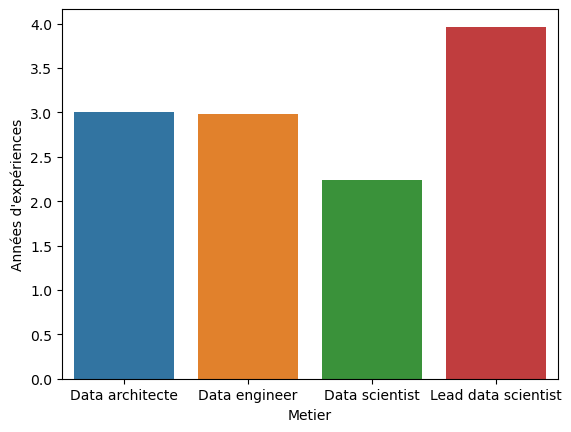

In [6]:
# on groupe en calculant la moyenne le nombre d'années d'expériences par métier
df_gb_experience = df['Experience'].groupby(df['Metier']).mean()
plt.figure()
sns.barplot(x=df_gb_experience.index, y=df_gb_experience)
plt.ylabel('Années d\'expériences')

In [7]:
# on utilise ici qcut pour séparer les valeurs de la colonne Experience en 4 quartiles pour avoir 
# une répartition correcte des valeurs dans chaque niveau d'expérience, les valeurs allant 
# de 0 à 21, et étant davantage réparties autour de petites valeurs (moins de 3.5)

print(pd.qcut(df['Experience'],4).value_counts())
df["Exp_label"] = pd.qcut(df['Experience'],4)

# on récupère les intervalles calculés 
intervs = df["Exp_label"].unique()
ind = intervs.argsort()
intervs = intervs[ind]

list_label = ['debutant', 'confirme', 'avance', 'expert']

for i in range(4):
    df["Exp_label"] = df["Exp_label"].replace(intervs[i], list_label[i])

df.drop(['Experience'], axis=1, inplace=True)

(-0.001, 1.0]    2811
(2.0, 3.5]       2524
(3.5, 21.0]      2174
(1.0, 2.0]       2031
Name: Experience, dtype: int64


Text(0, 0.5, "Nombre d'occurence de la technologie")

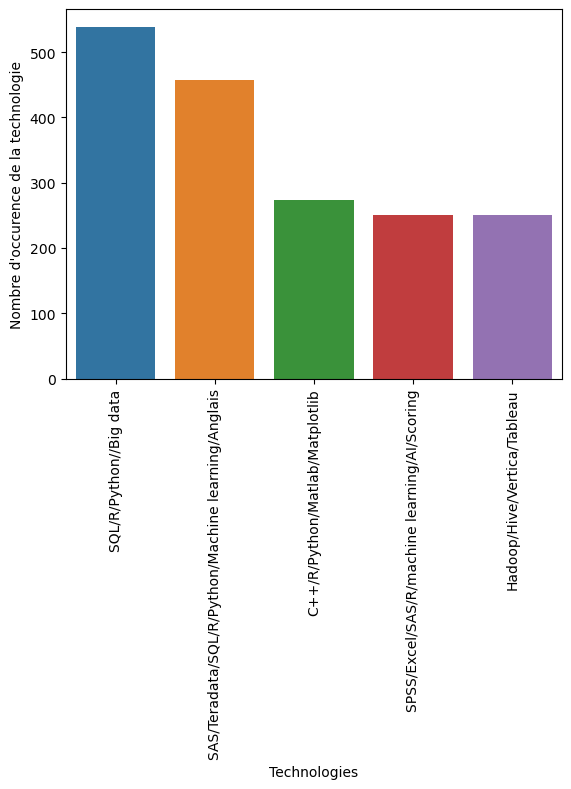

In [8]:
# on groupe par technologies en comptant le nombre d'occurence de chacune
df_gb_technologies = df['Technologies'].groupby(df['Technologies']).count()
# on trie le dataset obtenu dans l'ordre décroissant du nombre d'occurence 
df_gb_technologies = df_gb_technologies.sort_values(ascending=False)

plt.figure()
sns.barplot(x=df_gb_technologies.index[0:5], y=df_gb_technologies[0:5])
plt.xticks(rotation=90)
plt.ylabel('Nombre d\'occurence de la technologie')

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

print("Nombre de valeurs par colonne :")
print(df.nunique())

Nombre de valeurs par colonne :
Entreprise      1382
Metier             4
Technologies      57
Diplome            4
Ville             14
Exp_label          4
dtype: int64


In [10]:
# encoding des colonnes Diplome et Exp_label selon un ordre défini (celui du nombre d'années d'études /
# d'expérience)

diplome = ['No diploma', 'Bachelor', 'Master', 'Phd']
exp_label = ['debutant', 'confirme', 'avance', 'expert']
diplome_labels = df["Diplome"].copy()
exp_label_labels = df["Exp_label"].copy()

for i in range(4):
    diplome_labels = diplome_labels.replace(diplome[i], i)
    exp_label_labels = exp_label_labels.replace(exp_label[i], i)

# encoding des autres colonnes du dataset 
# on choisit ici un ordinal encoder plutôt qu'un one-hot encoder car les colonnes
# Entreprise, Technologies et Ville ont plus de 10 valeurs différentes chacune, 
# et pour Metier l'ordinal encoding nous permettra d'obtenir des classes qui nous serons
# utiles ensuite 
enc_cols = ['Entreprise', 'Metier', 'Technologies', 'Ville']
encoder = OrdinalEncoder()
enc_cols_df = pd.DataFrame(encoder.fit_transform(df[enc_cols]), columns = enc_cols)
enc_cols_df.index = df.index

# concaténation les colonnes obtenues 
df_enc = pd.concat([enc_cols_df, diplome_labels, exp_label_labels], axis=1)

# séparation du dataset en fonction de la connaissance ou non du métier 
df_enc_metier = df_enc[df_enc.Metier.isnull() == False].copy()
df_enc_metier_nan = df_enc[df_enc.Metier.isnull()].copy()

# séparation en data d'entrainement, de test et de validation
y = df_enc_metier['Metier']
X = df_enc_metier.drop(['Metier'], axis=1)
y_valid = df_enc_metier_nan['Metier']
X_valid = df_enc_metier_nan.drop(['Metier'], axis=1)

# on garde 80% du dataset avec le métier connu pour l'entrainement du modèle 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=0)

# changement des valeurs nulles en la médiane du dataset d'entrainement pour les colonnes autres que Metier 
imp = SimpleImputer(strategy = "median")
cols = X_train.columns
index = X_train.index
X_train = pd.DataFrame(imp.fit_transform(X_train), columns=cols, index=index)
index = X_test.index
X_test = pd.DataFrame(imp.transform(X_test), columns=cols, index=index)
index = X_valid.index
X_valid = pd.DataFrame(imp.transform(X_valid), columns=cols, index=index)

# applique une standardisation en fonction du dataset d'entrainement sur les données sauf pour Metier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols = X_train.columns
index = X_train.index
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = cols, index=index)
index = X_test.index
X_test = pd.DataFrame(scaler.transform(X_test), columns = cols, index=index)
index = X_valid.index
X_valid = pd.DataFrame(scaler.transform(X_valid), columns = cols, index=index)

Correlation avec Metier : 
 Metier          1.000000
Technologies    0.388275
Diplome         0.295521
Exp_label       0.027194
Ville           0.013976
Entreprise     -0.008264
Name: Metier, dtype: float64


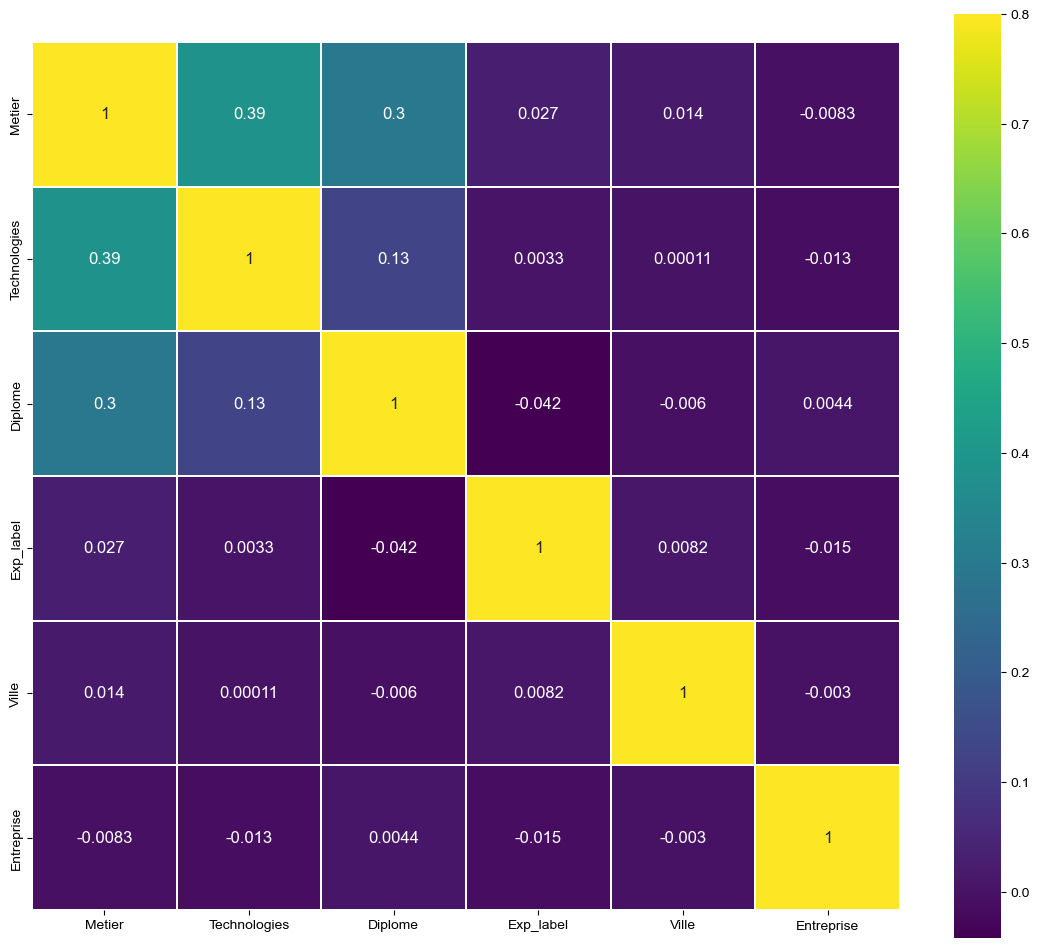

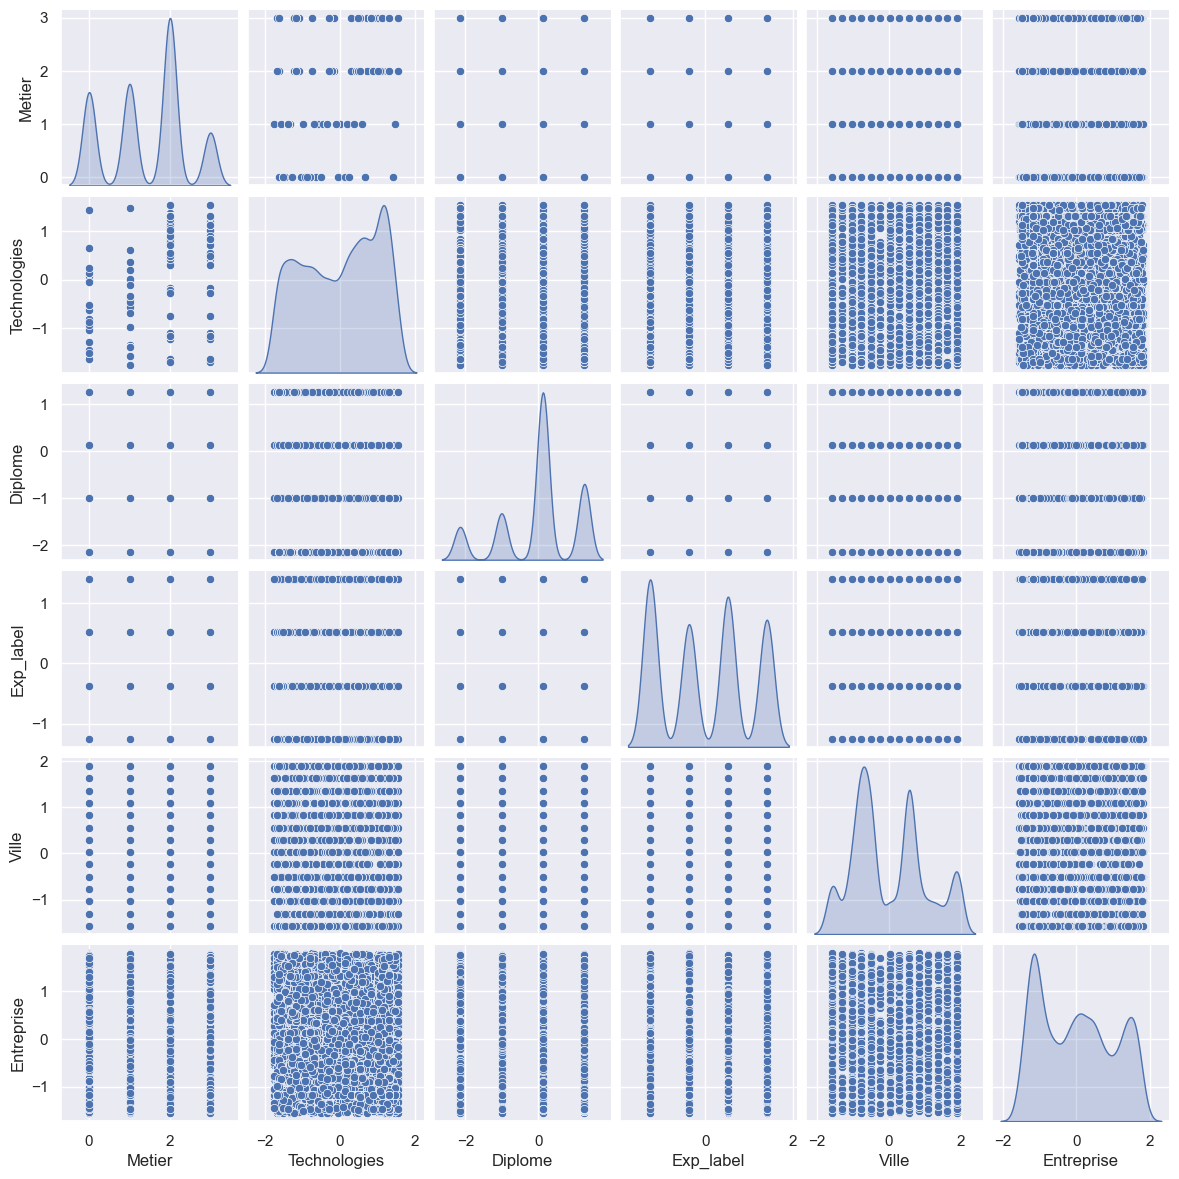

In [11]:
# recherche de corrélation entre les données 
train = X_train.copy()
train['Metier'] = y_train.copy()

correlation = train.corr()
k= train.shape[1]
cols = correlation.nlargest(k,'Metier')['Metier'].index

f, ax = plt.subplots(figsize = (14,12))
sns.heatmap(np.corrcoef(train[cols].values.T), vmax=.8, linewidths=0.01,square=True,annot=True,cmap='viridis',
            linecolor="white",xticklabels = cols.values ,annot_kws = {'size':12},yticklabels = cols.values)

print("Correlation avec Metier : \n", correlation.Metier.sort_values(ascending = False))

sns.set()
sns.pairplot(train[cols], height = 2 ,kind ='scatter',diag_kind='kde')
plt.show()


### Les colonnes ville et entreprise sont les moins corrélées avec le métier, et les autres colonnes ne présentent pas de corrélation entre elles. On peut donc enlever ces deux colonnes pour entrainer le modèle, et garder le reste des colonnes.

In [12]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

drop = ['Ville', 'Entreprise']
for d in drop:
    X_train.drop([d], axis=1, inplace=True)
    X_test.drop([d], axis=1, inplace=True)
    X_valid.drop([d], axis=1, inplace=True)

0.08529879098101117


<AxesSubplot:xlabel='Exp_label', ylabel='Diplome'>

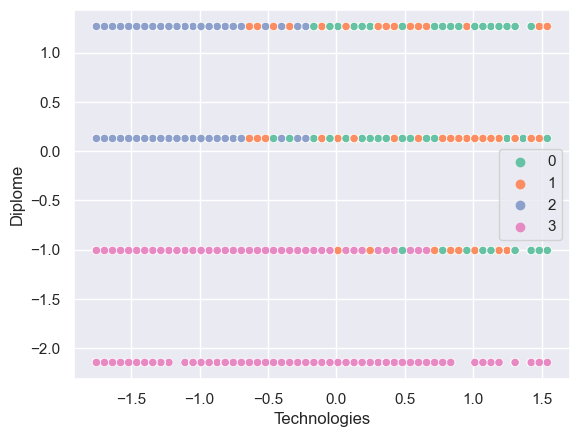

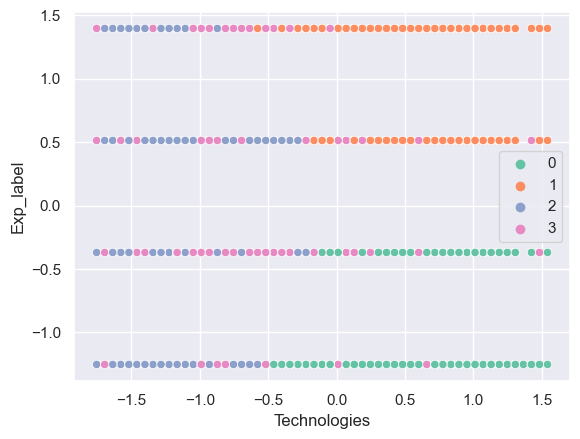

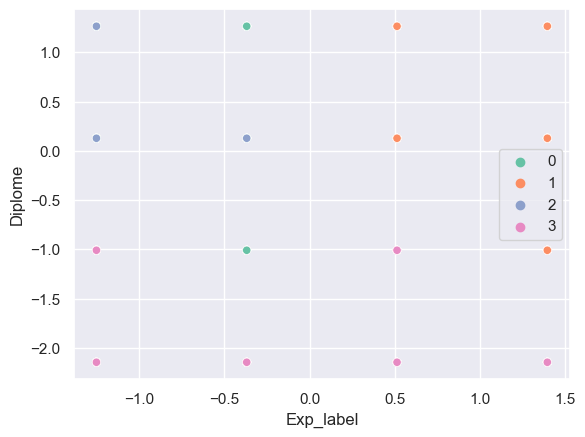

In [13]:
# on prend pour nombre de cluster le nombre de métier que l'on souhaite obtenir (4 différents)

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

km = KMeans(n_clusters=4, n_init=4)
km.fit(X_train)

print(adjusted_rand_score(km.labels_, y_train))

plt.figure()
sns.scatterplot(x=X_train['Technologies'], y=X_train['Diplome'], hue=km.labels_, palette='Set2')

plt.figure()
sns.scatterplot(x=X_train['Technologies'], y=X_train['Exp_label'], hue=km.labels_, palette='Set2')

plt.figure()
sns.scatterplot(x=X_train['Exp_label'], y=X_train['Diplome'], hue=km.labels_, palette='Set2')

0.07532086413611068


<AxesSubplot:xlabel='Exp_label', ylabel='Diplome'>

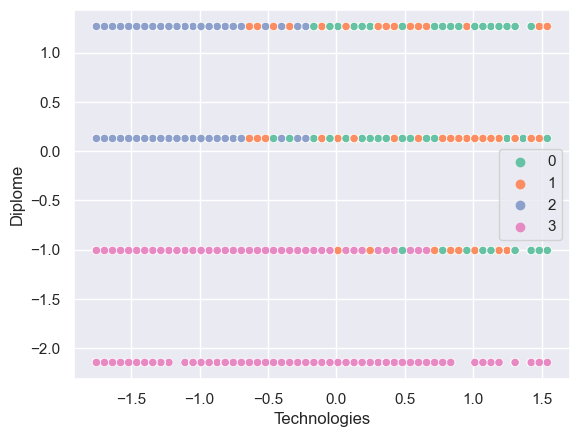

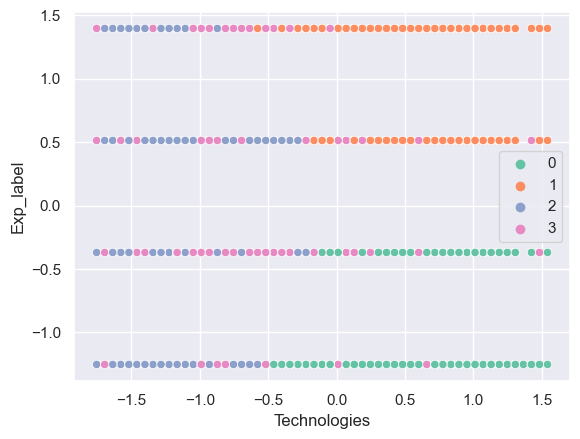

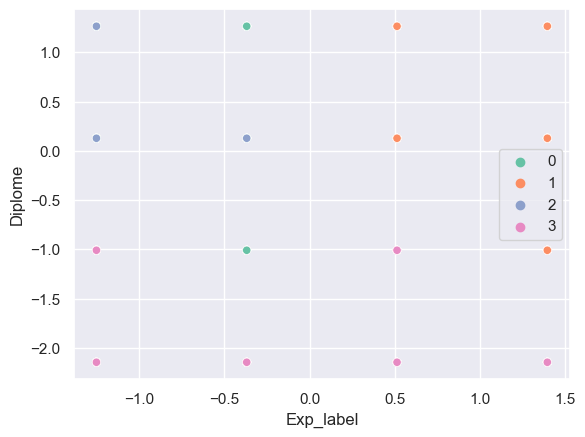

In [14]:
from sklearn.cluster import MiniBatchKMeans

mbkm = MiniBatchKMeans(n_clusters=4)
mbkm.fit(X_train)

print(adjusted_rand_score(mbkm.labels_, y_train))

plt.figure()
sns.scatterplot(x=X_train['Technologies'], y=X_train['Diplome'], hue=km.labels_, palette='Set2')

plt.figure()
sns.scatterplot(x=X_train['Technologies'], y=X_train['Exp_label'], hue=km.labels_, palette='Set2')

plt.figure()
sns.scatterplot(x=X_train['Exp_label'], y=X_train['Diplome'], hue=km.labels_, palette='Set2')


### La métrique choisie est ici adjusted_rand_score car elle permet de comparer les colonnes en tant que couple de valeur pour estimer le nombre de couple de valeurs qui s'accordent. La métrique est faible dans les deux cas, pour KMeans ou KMeans avec mini batchs, on peut donc penser qu'il n'y a pas de profil précis dans les données pour déterminer le métier d'une personne. 

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# les clusters non supervisés n'ayant pas l'air d'être pertinants dans ce cas, on choisit ici d'utiliser un 
# modèle supervisé de K plus proches voisins afin d'estimer les métiers manquant dans la base de données 

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# test de l'accuracy sur le data de test 
pred = pd.DataFrame(knn.predict(X_test))
print("Test accuracy : ", accuracy_score(pred, y_test))

# prediction des métiers non renseignés 
pred_nan = pd.DataFrame(knn.predict(X_valid))
pred_nan.index = X_valid.index
pred_nan.rename({0:'Metier'})

for i in range(4):
    pred_nan[pred_nan == i] = encoder.categories_[1][i]

df_valid = df[df.Metier.isnull()]
df_valid.drop(['Metier'], axis=1, inplace=True)
df_valid['Metier predit'] = pred_nan.copy()

print("Data avec les métiers prédits : \n", df_valid)

Test accuracy :  0.8442237323575535
Data avec les métiers prédits : 
                       Entreprise  \
346                       Jacobs   
2058              Ball Aerospace   
2670                  eHire, LLC   
2899       Norfolk Southern Corp   
3346       J.E. Ranta Associates   
4248                        KPMG   
4290         Pandora Media, Inc.   
4292    Partners HealthCare(PHS)   
5425           Ashton Lane Group   
5593     Lighthouse Lab Services   
5712              Ball Aerospace   
6024                      Leidos   
6625              Ball Aerospace   
7091                        KPMG   
7228  Environmental Defense Fund   
7330                      Turner   
9087   Klein Hersh International   
9427          McKinsey & Company   
9490                     Pearson   

                                           Technologies     Diplome  \
346                              Python/Spark/GNU/Linux  No diploma   
2058                                 VBA/Python/Excel/R      Master

/var/folders/71/s92l1qk55dzfqltvqzcq2jmr0000gn/T/ipykernel_15216/1206059221.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.drop(['Metier'], axis=1, inplace=True)
/var/folders/71/s92l1qk55dzfqltvqzcq2jmr0000gn/T/ipykernel_15216/1206059221.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Metier predit'] = pred_nan.copy()


### La métrique utilisée ici est l'accuracy car on connait déjà les valeurs que l'on souhaite obtenir pour les datasets d'entrainement et de test. L'accuracy est ici de 0.84 sur le dataset de test, ce qui signifie que le modèle reconnait bien les différents métiers sur les données testées. Les données prédites paraissent adéquates sur le dataset de validation, en accord avec l'expérience, le diplôme et les technologies de chaque personne observée. 